In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import gaussian, convolve
from scipy.integrate import simps

plt.rcParams["figure.figsize"] = (18, 9)

In [2]:
# NOTES:
# * lognorm: its parameters are "s = standard deviation", "scale = exp(mu)"

distributions_dict = {
    "norm": stats.norm,
    "gamma": stats.gamma,
    "lognorm": stats.lognorm,
    "beta": stats.beta
}

def component_rvs(distribution, params, size):
    f = distributions_dict[distribution](**params)
    return f.rvs(size)

def mixture_rvs(distributions, params, size, wts=None):
    if wts is None:
        wts = np.repeat(1 / len(distributions), len(distributions))
    assert len(distributions) == len(params) == len(wts)
    assert np.allclose(np.sum(wts), 1)
    sizes = np.round(np.array(wts) * size).astype(int)
    map_obj = map(lambda d, p, s: component_rvs(d, p, s), distributions, params, sizes)
    return np.concatenate(list(map_obj))

def distribution_bounds(distribution, params):
    bounds = {
    "norm" : lambda p: [p["loc"] - 3 * p["scale"], p["loc"] + 3 * p["scale"]],
    "gamma": lambda p: [0, stats.gamma.ppf(0.995, a=p["a"], scale=p["scale"])],
    "lognorm": lambda p: [0, stats.lognorm.ppf(0.995, s=p["s"], scale=p["scale"])],
    "beta": lambda p: [0, 1]}
    return bounds[distribution](params)

def mixture_bounds(distributions, params):
    map_obj = map(lambda d, p: distribution_bounds(d, p), distributions, params)
    vals = np.concatenate(list(map_obj))
    return [np.min(vals), np.max(vals)]

def mixture_grid(distributions, params):
    bounds = mixture_bounds(distributions, params)
    return np.linspace(bounds[0], bounds[1], num=500)

def component_pdf(distribution, params, grid):
    f = distributions_dict[distribution](**params)
    return f.pdf(grid)

def mixture_pdf(distributions, params, wts = None, grid = None):
    if wts is None:
        wts = np.repeat(1 / len(distributions), len(distributions))
    assert len(distributions) == len(params) == len(wts)
    assert np.allclose(np.sum(wts), 1)
    
    if grid is None:
        grid = mixture_grid(distributions, params)
    
    pdf = np.average(list((map(lambda d, p: component_pdf(d, p, grid), distributions, params))), 
                     axis=0, weights=wts)
    return grid, pdf

[-6, 6]
[0, 21.95495499065953]
[0, 17.003381463667015]
[0, 1]


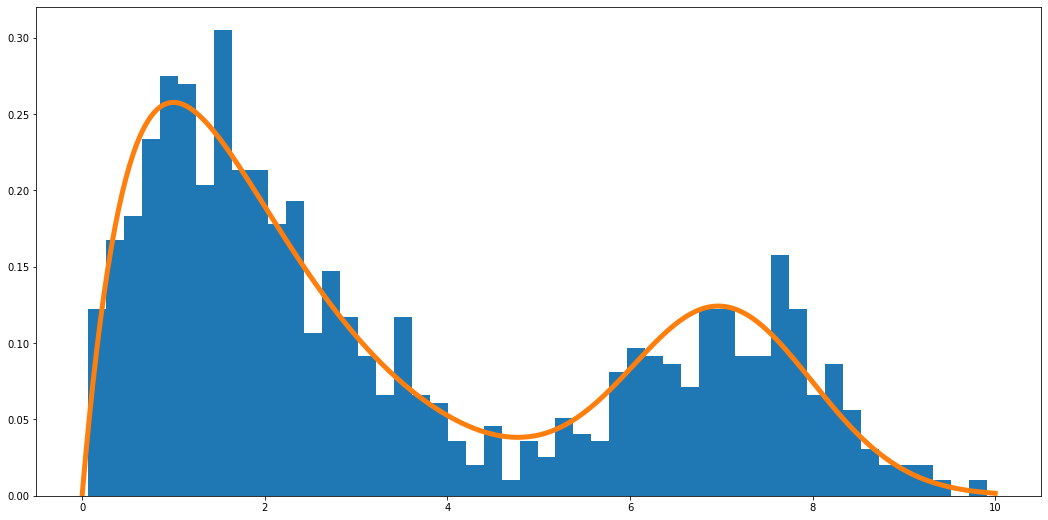

In [3]:
# Check bounds are working
print(distribution_bounds("norm", {"loc":0, "scale":2}))
print(distribution_bounds("gamma", {"a": 4, "scale": 2}))
print(distribution_bounds("lognorm", {"s": 1.1, "scale": 1}))
print(distribution_bounds("beta", {"a": 3, "b": 4}))

np.random.seed(2473)

d = ["norm", "gamma"]
p = [{"loc":7, "scale":1}, {"a": 2, "scale": 1}]
s = 100
wts = [0.3, 0.7]

rvs = mixture_rvs(d, p, 1000, wts)
x_line, y_line = mixture_pdf(d, p, wts)

plt.hist(rvs, bins = 50, density=True)
plt.plot(x_line, y_line, lw = 5); 

# Reimplementando el KDE

In [4]:
import sys
sys.path.append("..") 
from src import estimate_density, estimate_density_em
import numpy as np

In [5]:
rvs = np.random.normal(size = 200)
%timeit _, _ = estimate_density(rvs, bw="scott")

rvs = np.random.normal(size = 1000)
%timeit _, _ = estimate_density(rvs, bw="scott")

rvs = np.random.normal(size = 5000)
%timeit _, _ = estimate_density(rvs, bw="scott")

rvs = np.random.normal(size = 10000)
%timeit _, _ = estimate_density(rvs, bw="scott")

rvs = np.random.normal(size = 100000)
%timeit _, _ = estimate_density(rvs, bw="scott")

rvs = np.random.normal(size = 1000000)
%timeit _, _ = estimate_density(rvs, bw="scott")

144 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
145 µs ± 820 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
167 µs ± 763 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
192 µs ± 4.91 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
661 µs ± 6.48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
11.4 ms ± 69.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
# %load_ext line_profiler

In [7]:
rvs = np.random.normal(size = 100000)
# %lprun -f estimate_density estimate_density(rvs, bw="scott")

In [8]:
rvs = np.random.normal(size = 1000000)
# %lprun -f estimate_density estimate_density(rvs, bw="scott")

# AZ KDE COMPARISON

In [9]:
import numpy as np
from arviz_kde import fast_kde, fast_kde2
_, _, _ = fast_kde(np.random.normal(size=100)) # To cache numba

In [10]:
for size in [1000, 10000, 100000, 1000000]:
    rvs = np.random.normal(size = size)
    print("Size: " + str(size))
    %timeit pdf, xmin, xmax = fast_kde(rvs); np.linspace(xmin, xmax, len(pdf))
    %timeit grid, pdf = fast_kde2(rvs)

Size: 1000
155 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
89.4 µs ± 1.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Size: 10000
207 µs ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
135 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Size: 100000
738 µs ± 7.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
603 µs ± 25.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Size: 1000000
12.1 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.6 ms ± 52 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
rvs = np.random.normal(size = 100_000)
# %lprun -f fast_kde fast_kde(rvs)

In [12]:
rvs = np.random.normal(size = 100_000)
# %lprun -f fast_kde2 fast_kde2(rvs)

# COMPUTATION OF STANDARD DEVIATION

In [14]:
from stats_tests import std
import numpy as np
_ = std(np.random.normal(size = 100), 100) # to cache numba

In [15]:
for size in [1000, 10000, 100000, 1000000]:
    rvs = np.random.normal(size = size)
    print("Size: " + str(size))
    %timeit rvs.var() ** 0.5
    %timeit (((rvs ** 2).sum() / size) - (rvs.sum() / size) ** 2) ** 0.5
    %timeit std(rvs, size)

Size: 1000
28.1 µs ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
11.6 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.71 µs ± 80.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Size: 10000
50.4 µs ± 666 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
29.1 µs ± 118 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
28.2 µs ± 578 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Size: 100000
266 µs ± 5.27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
198 µs ± 3.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
294 µs ± 4.93 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Size: 1000000
8.46 ms ± 75.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.34 ms ± 55.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.16 ms ± 56.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# TEST SIMULATION PRODUCES RIGHT VALUES

In [1]:
import sys
sys.path.append("../simulation/") 
from sim_utils import plot_single
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 30)
%load_ext line_profiler

In [2]:
pdf_kwargs = {
    "gaussian_1": {
        "distribution": ["norm"],
        "params": [{"loc" : 0, "scale": 1}], 
        "wts": None,
        "bc": False 
    },
    "gaussian_2": {
        "distribution": ["norm"],
        "params": [{"loc" : 0, "scale": 2}], 
        "wts": None,
        "bc": False
    },
    "gmixture_1": {
        "distribution": ["norm", "norm"],
        "params": [{"loc": 0, "scale": 1}, {"loc": 0, "scale": 0.1}], 
        "wts": [0.667, 0.333],
        "bc": False
    },
    "gmixture_2": {
        "distribution": ["norm", "norm"],
        "params": [{"loc": -12, "scale": 0.5}, {"loc": 12, "scale": 0.5}], 
        "wts": None,
        "bc": False
    },
    "gmixture_3": {
        "distribution": ["norm", "norm"],
        "params": [{"loc": 0, "scale": 0.1}, {"loc": 5, "scale": 1}], 
        "wts": None,
        "bc": False
    },
    "gmixture_4": {
        "distribution": ["norm", "norm"],
        "params": [{"loc": 0, "scale": 1}, {"loc": 1.5, "scale": 0.33}], 
        "wts": [0.75, 0.25],
        "bc": False
    },
    "gmixture_5": {
        "distribution": ["norm", "norm"],
        "params": [{"loc": 3.5, "scale": 0.5}, {"loc": 9, "scale": 1.5}],
        "wts": [0.6, 0.4],
        "bc": False
    },
    "gamma_1": {
        "distribution": ["gamma"], 
        "params": [{"a": 1, "scale": 1}], 
        "wts": None,
        "bc": True
    },
    "gamma_2": {
        "distribution": ["gamma"], 
        "params": [{"a": 2, "scale": 1}], 
        "wts": None,
        "bc": True
    },
    "beta_1": {
        "distribution": ["beta"], 
        "params": [{"a" : 2.5, "b" : 1.5}], 
        "wts": None,
        "bc": True
    },
    "logn_1": {
        "distribution": ["lognorm"],         
        "params": [{"s": 1, "scale": 1}], 
        "wts": None,
        "bc": True
    },
    "skwd_mixture1": {
        "distribution": ["gamma", "norm", "norm"],
        "params": [{"a": 1.5, "scale": 1}, {"loc": 5, "scale": 1}, {"loc": 8, "scale": 0.75}],
        "wts": [0.7, 0.2, 0.1],
        "bc": True
    }
}

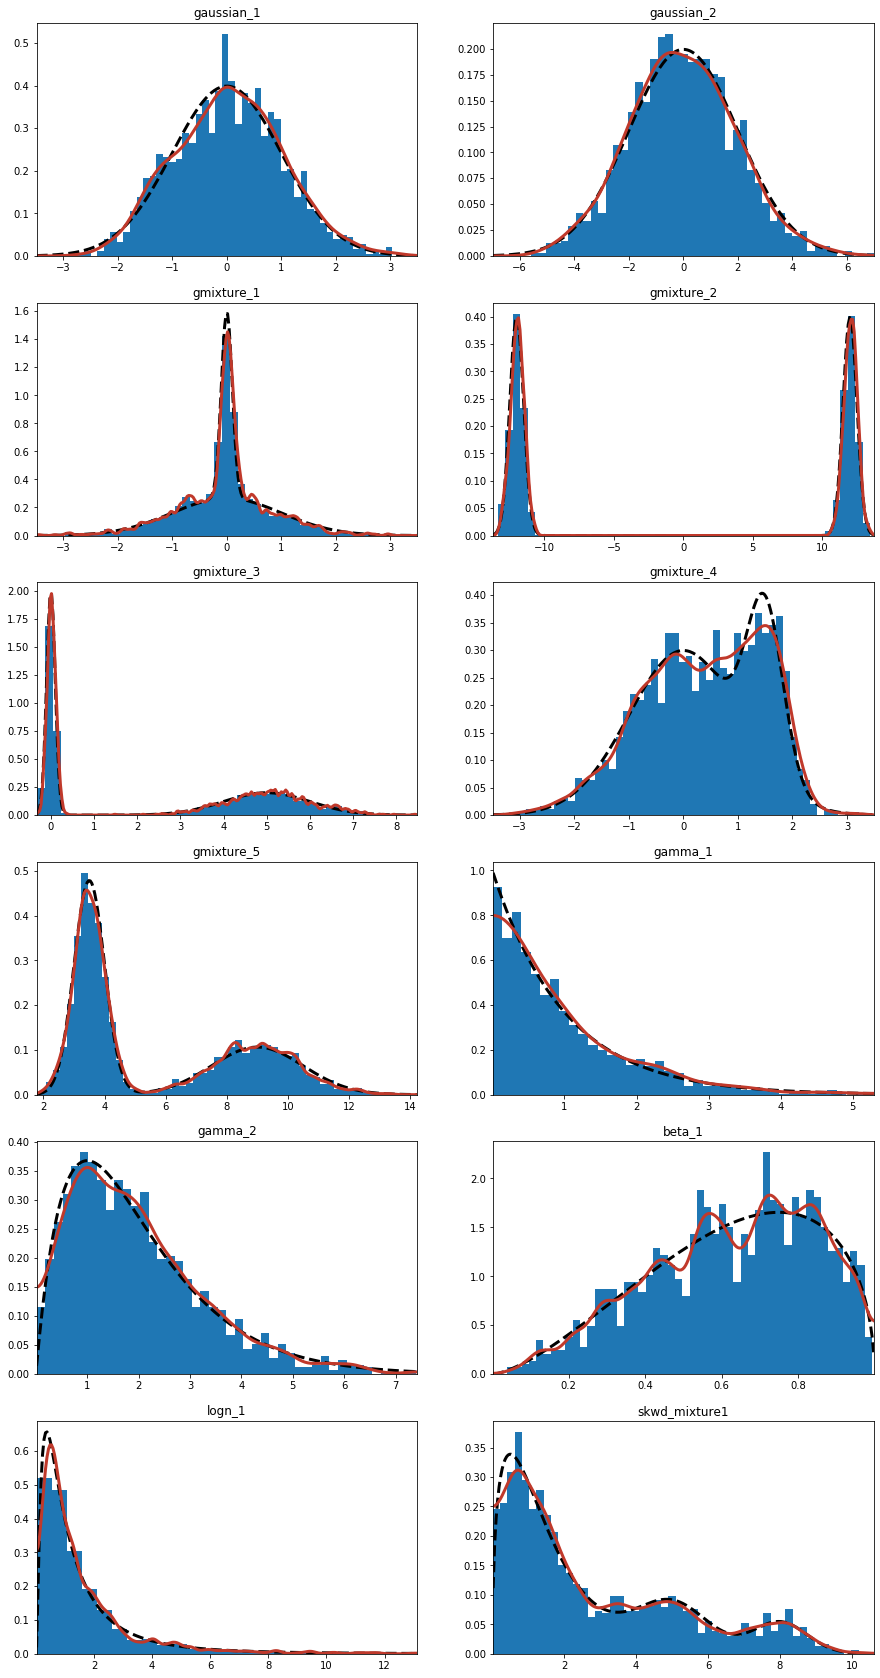

In [7]:
# %lprun -f plot_single plot_single(pdf_kwargs, adaptive=True, bw="scott", size=500, mixture=False)
plot_single(pdf_kwargs, adaptive=False, bw="isj", size=1500, mixture=False)

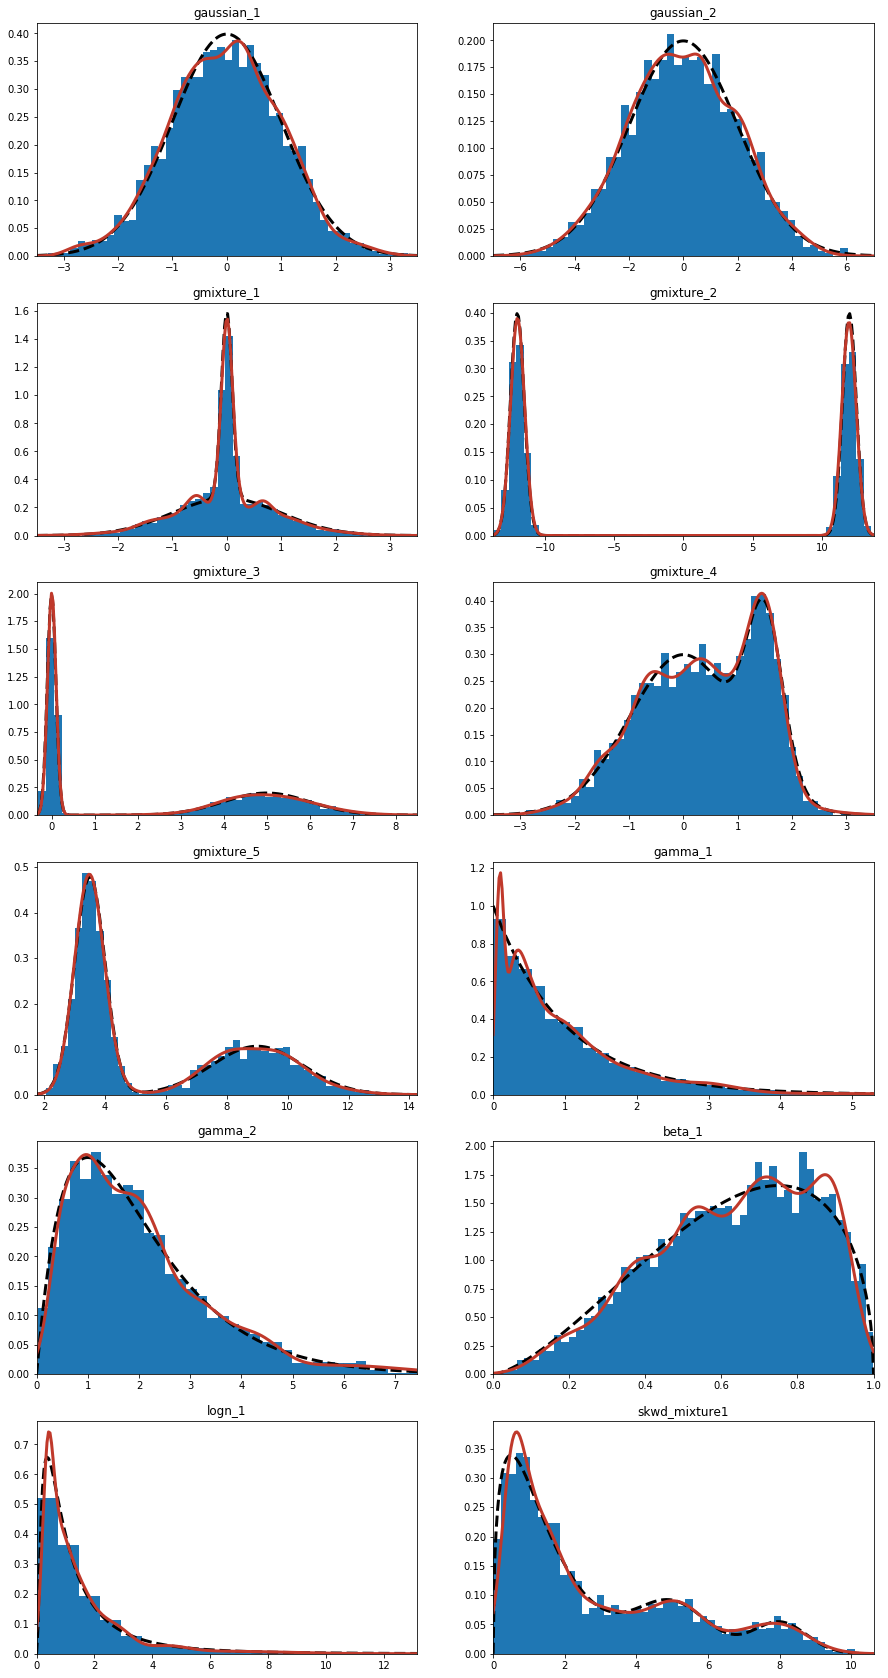

In [4]:
plot_single(pdf_kwargs, adaptive=False, bw="mixture", size=2500, mixture=True)

# IMPROVE SJ TIME

In [2]:
import numpy as np
from scipy import stats
from scipy.optimize import fsolve

def bw_sj(x):

    x_len = len(x)
    x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
    q75, q25 = np.percentile(x, [75 ,25])
    x_iqr = q75 - q25
    h0 = 0.9 * x_std * x_len ** (-0.2)

    a = 0.92 * x_iqr * x_len ** (-1 / 7)
    b = 0.912 * x_iqr * x_len ** (-1 / 9)

    x_len_mult = 1 / (x_len * (x_len - 1))
    
    s_a, t_b = _sj_constants(x, _phi6, _phi4, b, a, x_len_mult)
    result = fsolve(_sj_optim_fun, h0, args=(s_a, t_b, x, x_len, x_len_mult))
        
    return result[0]
    
def _phi6(x):
    return (x ** 6 - 15 * x ** 4 + 45 * x ** 2 - 15) * _gaussian_pdf(x)

def _phi4(x):
    return (x ** 4 - 6 * x ** 2 + 3) * _gaussian_pdf(x)

def _gaussian_pdf(x):
    return 0.3989422804 * np.exp(-0.5 * x ** 2)

def pairwise_diff(x):
    x_len = len(x)
    diff_len = x_len * (x_len - 1) // 2
    idx = np.concatenate(([0], np.arange(x_len - 1, 0, -1).cumsum()))
    start, stop = idx[:-1], idx[1:]
    diff = np.empty(diff_len, dtype=x.dtype)
    for j, i in enumerate(range(x_len - 1)):
        diff[start[j]:stop[j]] = x[i, None] - x[i + 1:]
    return diff

def _sj_double_sum(x, fun, den):
    # Exploits the fact that _phi4 and _phi6 are symmetric and 
    # the diagonal of the difference matrix is 0
    diff = pairwise_diff(x)
    diff /= den
    out = (fun(diff)).sum() * 2 + (fun(0) * len(x)).sum()
    return out

def _sj_constants(x, f1, f2, c1, c2, mult):
    t_b = _sj_double_sum(x, f1, c1)
    t_b *= - mult * c1 ** -7
    s_a = _sj_double_sum(x, f2, c2)
    s_a *= mult * c2 ** -5
    return t_b, s_a

def _sj_optim_fun(h, s_a, t_b, x, x_len, x_len_mult):  # pylint: disable=too-many-arguments
    numerator = 0.375 * np.pi ** -0.5
    g_h = 1.357 * np.abs(s_a / t_b) ** (1 / 7) * h ** (5 / 7)
    
    s_g = _sj_double_sum(x, _phi4, g_h)
    s_g *= x_len_mult * g_h ** -5

    output = (numerator / np.abs(s_g * x_len)) ** 0.2 - h

    return output

In [3]:
%load_ext line_profiler
rvs = np.random.normal(size=1000)
%lprun -f bw_sj bw_sj(rvs)

In [98]:
def sum1(x, fun, den):
    out = 0
    for x_i in x:
        out += (fun((x_i - x) / den)).sum()
    return out

def sum2(x, fun, den):
    out = np.sum(np.sum(fun(x / den), 0))
    return out

def pairwise_diff(x):
    x_len = len(x)
    diff_len = x_len * (x_len - 1) // 2
    idx = np.concatenate(([0], np.arange(x_len - 1, 0, -1).cumsum()))
    start, stop = idx[:-1], idx[1:]
    diff = np.empty(diff_len, dtype=x.dtype)
    for j, i in enumerate(range(x_len - 1)):
        diff[start[j]:stop[j]] = x[i, None] - x[i + 1:]
    return diff

def sum3(x, fun, den):
    diff = pairwise_diff(x)
    diff /= den
    out = (fun(diff)).sum() * 2 + (fun(0) * len(x)).sum()
    return out